# Le classifier bayésien naïf pour la détection de spam

Nous utilisons ici le modèle naif du classifier de Bayes. La vectorisation des mots s'appuie sur le TF-IDF. 

## Chargement des librairies nécessaires et de la base de données

Les packages utilisés sont répertoriés dans les  requirements. 
La construction de la base de données est rappelée dans le readme. 

In [13]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
test_data=pd.read_parquet('mails_spam_clean.parquet')
test_data.head()

,body,Spam
0,"New CMK/Special Hobby accessories, Flyhawk 1/7...",True
1,"Chère/Cher spam.sep.2022.2023@gmail.com, Votre...",True
2,"Chère/Cher spam.sep.2022.2023@gmail.com, Votre...",True
3,"Chère/Cher spam.sep.2022.2023@gmail.com, Votre...",True
4,"Chère/Cher spam.sep.2022.2023@gmail.com, Votre...",True


In [15]:
#on passe d'un fichier parquet à un fichier csv
df= test_data
df.to_csv("data.csv", index=False, sep=";")

## Manipulations de la base de données
### Vérifications de l'équilibre de la base
On sépare notre base en deux jeux de données selon les deux modalités de la variable catégorielle Spam, "Spam" pour les spams et "Ham" pour les non-spams. 

In [16]:
df_spam = df[df['Spam']==True]
df_ham = df[df['Spam']==False]

print("Taille des non-spams", df_ham.shape)
print("Taille des spams", df_spam.shape)

Taille des non-spams (1000, 2)
Taille des spams (1000, 2)


In [17]:
# Notre base est équilibrée : 1000 spams et 1000 non-spams. 
# On concatene les deux jeux de données
df_balanced = pd.concat([df_spam , df_ham])

### Partition en base d'apprentissage et de test

Nos variables explicatives sont contenues dans le corps du mail (body). On leur attribue X. 
La variable expliquée est la catégorie, spam ou non spam, (Spam). On lui attribue y. 

On crée donc quatre objets : X_train et y_train pour l'apprentissage d'une part, X_test et y_test pour le test d'autre part. 
La moitié des observations est utilisée pour l'apprentissage et l'autre pour le test. 

In [18]:
X=df_balanced["body"]
y=df_balanced["Spam"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=13,
                                                    shuffle=True , stratify=y)


### Création de notre pipeline

Notre pipeline a deux étapes : d'abord la vectorisation des mots du mail, éléments contenus dans l'objet X, puis la classification bayésienne naïve. 

In [19]:
pipe = Pipeline(steps=[('vectorize', CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b')),
                       ('classifier', MultinomialNB())])
#application du pipeline à notre base d'apprentissage
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize', CountVectorizer(token_pattern='\\b\\w+\\b')),
                ('classifier', MultinomialNB())])

### Application du modèle
Notre modèle est entraîné sur les bases d'apprentissage. 

On crée la variable y_predict qui contient la prédiction de la variable spam. Elle dépend des mots des mails de la base de test, les variables explicatives dans X_test. 

In [20]:
y_predict = pipe.predict(X_test)

### Evaluer le modèle

On évalue le modèle en fonction de la qualité de sa prédiction de spams et de non-spam. 


0.888
              precision    recall  f1-score   support

       False       0.82      0.99      0.90       500
        True       0.99      0.78      0.87       500

    accuracy                           0.89      1000
   macro avg       0.91      0.89      0.89      1000
weighted avg       0.91      0.89      0.89      1000



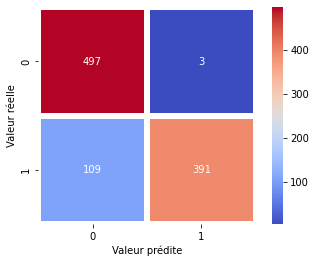

In [21]:
#Afficher les métriques d'évaluation accuracy, precision, recall
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))
#Graphique : matrice de confusion
mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='coolwarm', linewidths=5)
#titres des axes 
plt.xlabel('Valeur prédite')
plt.ylabel('Valeur réelle')
#montrer le graphique
plt.show()

Malgré l'hypothèse naive de l'indépendance des étiquettes, le classifier donne des résultats intéressants. 

89% des prédictions sont justes.

Parmi les 500 non-spams, 497 ont été prédits non spams et 3 spams. 
Cependant, parmi les 500 spams, seuls 391 spams ont été prédits spams et les 109 spams restants n'ont pas été filtrés. 

Ce premier modèle n'est pas assez performant. 